In [70]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from IPython.display import Audio

In [79]:
SAMPLE_RATE = 16000
N_MELS = 64 
BATCH_SIZE = 32
DATA_DIR = 'audio_data/train/audio'
VAL_LIST = 'audio_data/train/validation_list.txt'
TEST_LIST = 'audio_data/train/testing_list.txt'

class AudioTransform:
    def __init__(self, sample_rate=SAMPLE_RATE, n_mels=N_MELS):
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels
        )
        self.db = torchaudio.transforms.AmplitudeToDB()

    def __call__(self, waveform):
        return self.db(self.mel(waveform))

class AudioDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        self.fixed_length = 32  # number of time frames

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(path)

        # Convert to MelSpectrogram
        mel_spec = T.MelSpectrogram(sample_rate=sr, n_mels=64)(waveform)
        mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec, multiplier=10, db_multiplier=0, amin=1e-10, top_db=80)

        # Fix time dimension by padding or cropping
        if mel_spec.shape[-1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec.shape[-1]
            mel_spec = F.pad(mel_spec, (0, pad_width))
        else:
            mel_spec = mel_spec[..., :self.fixed_length]

        return mel_spec, label
    
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (B, 32, H, W)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B, 32, H/2, W/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, H/2, W/2)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B, 64, H/4, W/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (B, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B, 128, H/8, W/8)
        )

        self.gap = nn.AdaptiveAvgPool2d((4, 4))  # Ensures consistent output size

        self.fc = nn.Sequential(
            nn.Flatten(),                 # (B, 128*4*4 = 2048)
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        return self.fc(x)


def get_all_labels(base_dir):
    return sorted([
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d != '_background_noise_'
    ])    

In [80]:
labels = get_all_labels(DATA_DIR)
le = LabelEncoder()
le.fit(labels)

transform = AudioTransform()
train_file = 'audio_data/train/training_list.txt'

# Auto-create training_list.txt
if not os.path.exists(train_file):
    val_set = set(open(VAL_LIST).read().splitlines())
    test_set = set(open(TEST_LIST).read().splitlines())
    all_files = []
    for label in labels:
        folder = os.path.join(DATA_DIR, label)
        for f in os.listdir(folder):
            rel_path = os.path.join(label, f)
            if rel_path not in val_set and rel_path not in test_set:
                all_files.append(rel_path)
    with open(train_file, 'w') as f:
        for path in all_files:
            f.write(f"{path}\n")

def load_file_paths(file_list_path, base_dir):
    with open(file_list_path, 'r') as f:
        files = [os.path.join(base_dir, line.strip()) for line in f]
    return files

train_files = load_file_paths(train_file, DATA_DIR)
val_files = load_file_paths(VAL_LIST, DATA_DIR)
test_files = load_file_paths(TEST_LIST, DATA_DIR)

# Extract labels from file paths
train_labels = [os.path.basename(os.path.dirname(f)) for f in train_files]
val_labels = [os.path.basename(os.path.dirname(f)) for f in val_files]
test_labels = [os.path.basename(os.path.dirname(f)) for f in test_files]

# Encode labels
le = LabelEncoder()
train_targets = le.fit_transform(train_labels)
val_targets = le.transform(val_labels)
test_targets = le.transform(test_labels)

# Create datasets
train_ds = AudioDataset(train_files, train_targets, transform=transform)
val_ds = AudioDataset(val_files, val_targets, transform=transform)
test_ds = AudioDataset(test_files, test_targets, transform=transform)


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout = 0.3
epochs = 50
model = CNNClassifier(n_classes=len(labels), dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

def train_one_epoch(model, optimizer, train_dl, device):
    model.train()
    total_loss, total_correct = 0, 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = F.cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item() * xb.size(0)
        total_correct += (out.argmax(1) == yb).sum().item()
    return total_loss / len(train_ds), total_correct / len(train_ds)

def evaluate(dl, model):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            correct += (preds == yb).sum().item()
    return correct / len(dl.dataset), all_preds, all_labels

In [83]:
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, optimizer, train_dl, device)
    val_acc, _, _ = evaluate(val_dl, model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train acc = {train_acc:.4f}, Val acc = {val_acc:.4f}")
    

Epoch 1: Train acc = 0.1482, Val acc = 0.2689
Epoch 2: Train acc = 0.2847, Val acc = 0.3548
Epoch 3: Train acc = 0.3436, Val acc = 0.3928
Epoch 4: Train acc = 0.3758, Val acc = 0.4061
Epoch 5: Train acc = 0.3990, Val acc = 0.4238
Epoch 6: Train acc = 0.4163, Val acc = 0.4284
Epoch 7: Train acc = 0.4331, Val acc = 0.4434
Epoch 8: Train acc = 0.4454, Val acc = 0.4492
Epoch 9: Train acc = 0.4550, Val acc = 0.4419
Epoch 10: Train acc = 0.4630, Val acc = 0.4526
Epoch 11: Train acc = 0.4719, Val acc = 0.4606
Epoch 12: Train acc = 0.4787, Val acc = 0.4594
Epoch 13: Train acc = 0.4860, Val acc = 0.4601
Epoch 14: Train acc = 0.4952, Val acc = 0.4672
Epoch 15: Train acc = 0.4993, Val acc = 0.4721
Epoch 16: Train acc = 0.5068, Val acc = 0.4663
Epoch 17: Train acc = 0.5135, Val acc = 0.4719
Epoch 18: Train acc = 0.5169, Val acc = 0.4662
Epoch 19: Train acc = 0.5248, Val acc = 0.4678
Epoch 20: Train acc = 0.5282, Val acc = 0.4740
Epoch 21: Train acc = 0.5358, Val acc = 0.4713
Epoch 22: Train acc = 

In [84]:
torch.save(model.state_dict(), "cnn_audio_classifier.pt")

In [85]:
# model_2 = CNNClassifier(n_classes=len(labels))
# model_2.load_state_dict(torch.load('cnn_audio_classifier.pt'))

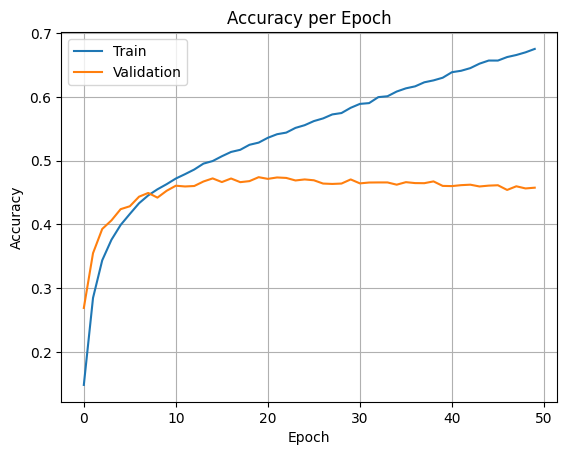

Test Accuracy: 0.4588

Classification Report:

              precision    recall  f1-score   support

         bed       0.26      0.43      0.32       176
        bird       0.33      0.34      0.34       158
         cat       0.34      0.43      0.38       166
         dog       0.46      0.47      0.47       180
        down       0.37      0.43      0.40       253
       eight       0.43      0.49      0.46       257
        five       0.56      0.44      0.49       271
        four       0.54      0.42      0.47       253
          go       0.39      0.35      0.37       251
       happy       0.40      0.39      0.40       180
       house       0.52      0.56      0.54       150
        left       0.54      0.43      0.47       267
      marvin       0.79      0.57      0.66       162
        nine       0.53      0.45      0.49       259
          no       0.33      0.41      0.37       252
         off       0.42      0.42      0.42       262
          on       0.44      0.34 

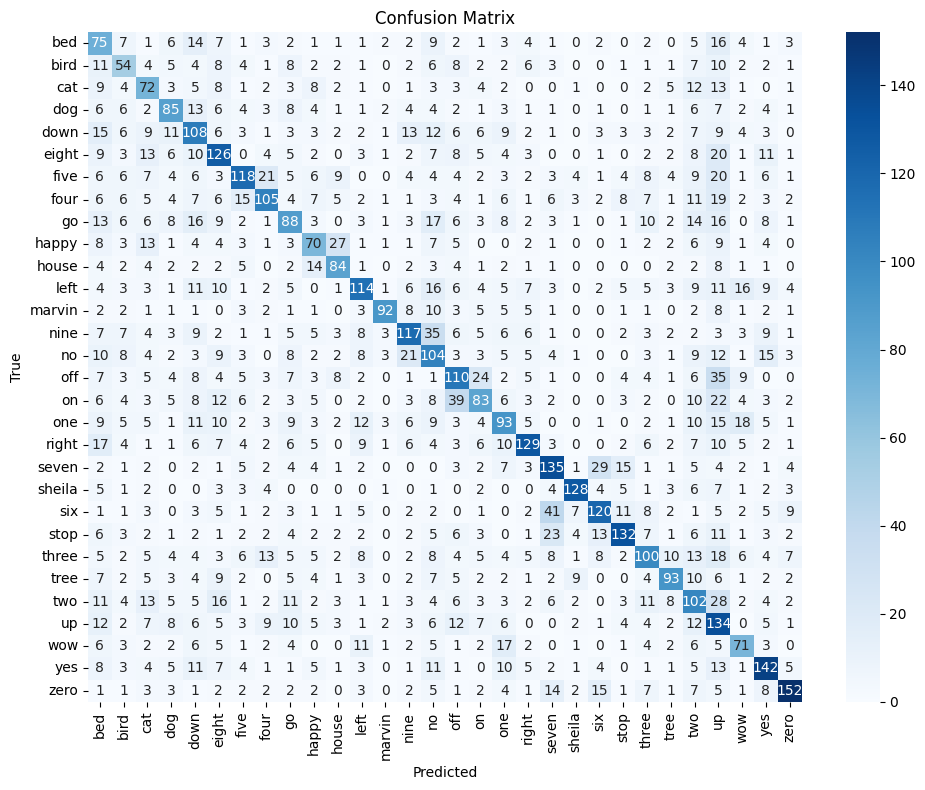

In [86]:
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

test_acc, preds, truths = evaluate(test_dl, model)
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(truths, preds, target_names=le.classes_))

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(truths, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

CNNClassifier(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=512, bia

In [ ]:
# Audio Transform preview

# Get the first training sample (waveform, label)
waveform, label = train_ds[0]  # this returns a transformed spectrogram
# To show raw waveform, we need to load the original file

# Load original waveform (without transform)
original_waveform, sample_rate = torchaudio.load(train_files[0])

# Plot raw waveform
plt.figure(figsize=(12, 4))
plt.plot(original_waveform.t().numpy())
plt.title(f'Raw Waveform - Label: {le.inverse_transform([label])[0]}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Apply transformation manually to see spectrogram
transform = AudioTransform()
spec = transform(original_waveform)

# Plot spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spec.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Get the first training sample (waveform, label)
waveform, label = train_ds[2000]  # this returns a transformed spectrogram
# To show raw waveform, we need to load the original file

# Load original waveform (without transform)
original_waveform, sample_rate = torchaudio.load(train_files[2000])

# Plot raw waveform
plt.figure(figsize=(12, 4))
plt.plot(original_waveform.t().numpy())
plt.title(f'Raw Waveform - Label: {le.inverse_transform([label])[0]}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Apply transformation manually to see spectrogram
transform = AudioTransform()
spec = transform(original_waveform)

# Plot spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spec.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()


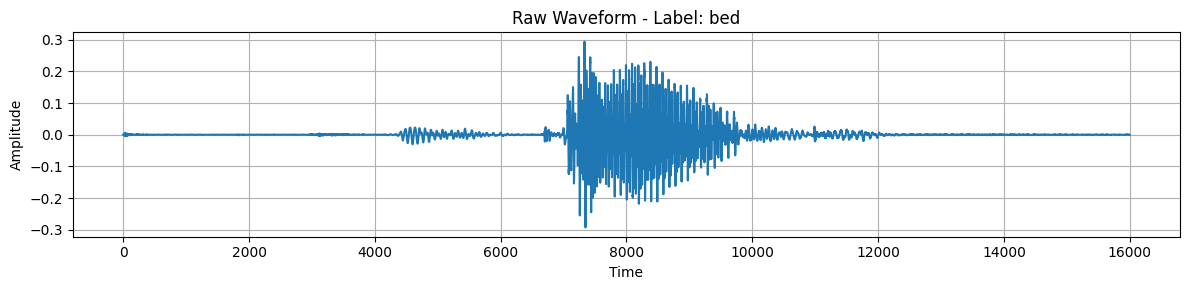

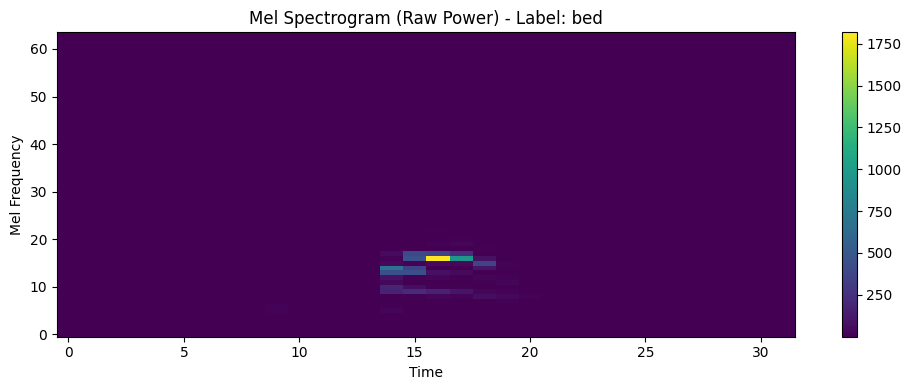

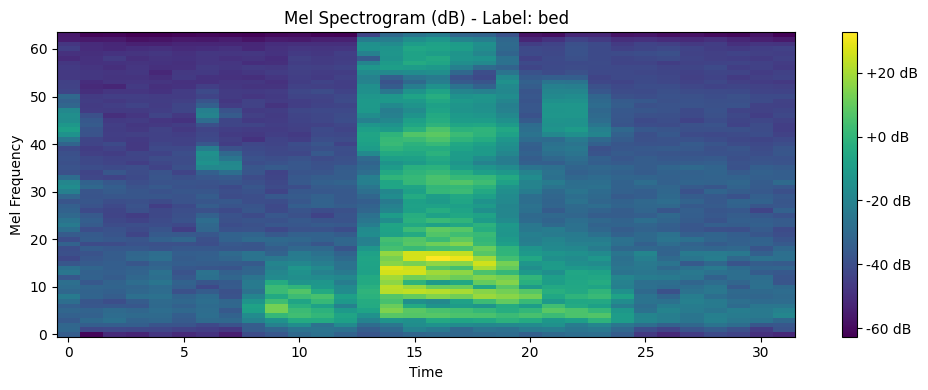

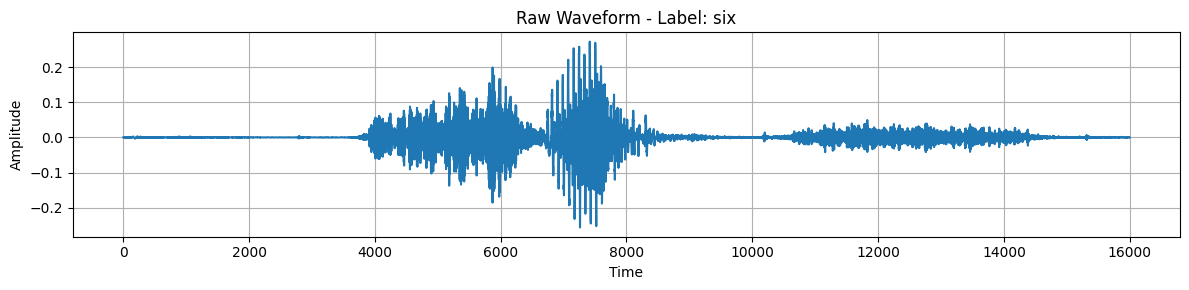

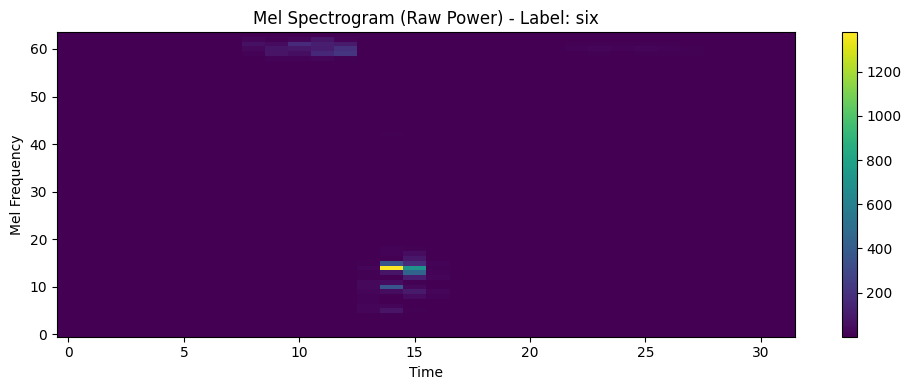

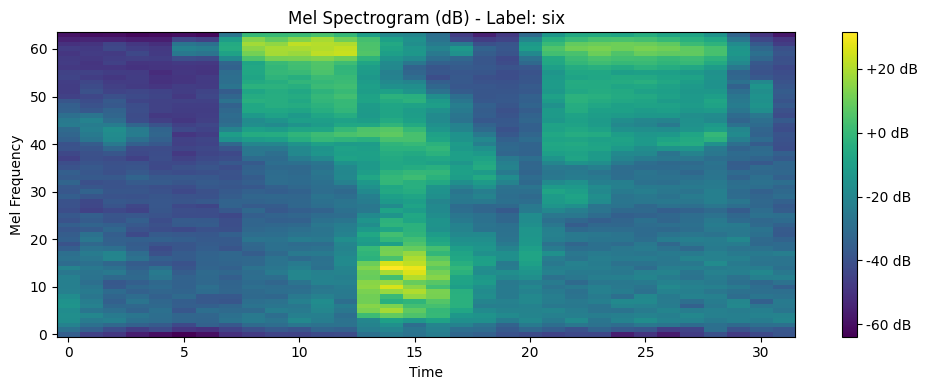

In [100]:
def show_sample(sample_path):

    # Load the original waveform
    waveform, sample_rate = torchaudio.load(sample_path)

    label = sample_path.split('/')[-2]

    # Initialize mel spectrogram and dB transforms
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=N_MELS
    )
    db_transform = torchaudio.transforms.AmplitudeToDB()

    # Step 1: Plot raw waveform
    plt.figure(figsize=(12, 3))
    plt.plot(waveform.t().numpy())
    plt.title(f'Raw Waveform - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 2: Apply MelSpectrogram (before AmplitudeToDB)
    mel_spec = mel_transform(waveform)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f'Mel Spectrogram (Raw Power) - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Step 3: Apply AmplitudeToDB to the Mel Spectrogram
    mel_spec_db = db_transform(mel_spec)

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec_db.squeeze().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.title(f'Mel Spectrogram (dB) - Label: {label}')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    

show_sample(f'{DATA_DIR}/bed/0a7c2a8d_nohash_0.wav') 
show_sample(f'{DATA_DIR}/six/0a7c2a8d_nohash_0.wav') 
